<a href="https://colab.research.google.com/github/baussel/Satellite_Detection/blob/main/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classifier - Satellite vs No Satellite

*Ben Aussel, ESA, August 2021*

## Code Preparation

In [ ]:
#Installation of missing modules
!pip install wandb #Weights and Biases - For logging the training runs
!pip install pyyaml h5py  #Required to save models in HDF5 format

     |████████████████████████████████| 1.7 MB 4.1 MB/s 
     |████████████████████████████████| 170 kB 46.8 MB/s 
     |████████████████████████████████| 188 kB 52.3 MB/s 
     |████████████████████████████████| 133 kB 58.8 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=344c33f67da33d5852ead4bca83f0a83083d8c645e6ced29825514bf795cd41f
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
#Import of the relevant modules
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds

#Connection to Weight and Biases (https://wandb.ai)
import wandb
from wandb.keras import WandbCallback

## Data Preparation

In [ ]:
#Mount Google Drive with this Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Paramters for the images
img_height = 600
img_width = 600

#Batch_size - Size of used images per step
batch_size = 15

#Image Path
image_path = '/content/drive/MyDrive/ESA/Data/satellite_det/raw_images2'

In [ ]:
#Definition of the training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_path,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode = "binary") #Maybe change color_mode to grayscale for satellites

Found 1035 files belonging to 2 classes.
Using 828 files for training.


In [ ]:
#Definition of the validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  image_path,
  validation_split= 0.2 ,
  subset = "validation",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size,
  label_mode = "binary") #Maybe change color_mode to grayscale for satellites

Found 1035 files belonging to 2 classes.
Using 207 files for validation.


In [ ]:
#Return the class names
class_names = train_ds.class_names
print("Classes:",class_names)

Classes: ['no_satellite', 'satellite']


In [ ]:
print("Shape of the Dataset:")
print(train_ds)

Shape of the Dataset:
<BatchDataset shapes: ((None, 600, 600, 3), (None, 1)), types: (tf.float32, tf.float32)>


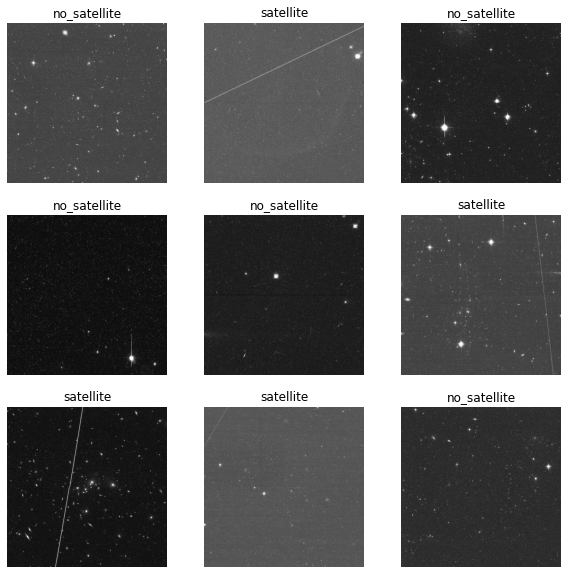

In [ ]:
#Example Images
plt.figure(figsize=(10, 10))
for images,labels in train_ds.take(1): #Takes the first batch
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

## Creating the model

Using the Inceptionv3 model

In [ ]:
#Download weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-07-30 09:34:11--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   228MB/s    in 0.4s    

2021-07-30 09:34:12 (228 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
#Use the existing InceptionV3 model for this classification
from tensorflow.keras.applications.inception_v3 import InceptionV3

#Save the model and load the downloaded weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(img_height, img_width, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

#Set the model to not trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
#Learning rate
learn_rate = 0.0005

In [ ]:
#Definition of the layers of the model
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
  pre_trained_model,
  layers.Flatten(),
  layers.Dense(128, activation = 'relu'),
  #Dropout
  layers.Dropout(0.5),
  #Output
  layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
#Compiling of the model, loss function is binary
model.compile(optimizer = 'adam', #Adam automatically uses the best learning rate
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
#Overview over the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 600, 600, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 17, 17, 2048)      21802784  
_________________________________________________________________
flatten (Flatten)            (None, 591872)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               75759744  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 97,562,657
Trainable params: 75,759,873
Non-trainable params: 21,802,784
___________________________________

## Training of the model

In [ ]:
#Connection to Weights and Biases
#parameters
config = wandb.config
config.learning_rate = learn_rate
wandb.init(project = 'image_classifier_inception')

#Number of epochs for the training
epoch_number = 30

#Starting the training and storing the result in 'history'
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epoch_number,
  callbacks = [WandbCallback()])

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/30
56/56 [==============================] - 292s 5s/step - loss: 11.4601 - accuracy: 0.7222 - val_loss: 0.2459 - val_accuracy: 0.9372
Epoch 2/30
56/56 [==============================] - 17s 254ms/step - loss: 0.4849 - accuracy: 0.8551 - val_loss: 0.2909 - val_accuracy: 0.9372
Epoch 3/30
56/56 [==============================] - 15s 255ms/step - loss: 0.3205 - accuracy: 0.8720 - val_loss: 0.2447 - val_accuracy: 0.9275
Epoch 4/30
56/56 [==============================] - 14s 248ms/step - loss: 0.2923 - accuracy: 0.9203 - val_loss: 0.2697 - val_accuracy: 0.9469
Epoch 5/30
56/56 [==============================] - 14s 249ms/step - loss: 0.1782 - accuracy: 0.9324 - val_loss: 0.1868 - val_accuracy: 0.9324
Epoch 6/30
56/56 [==============================] - 14s 250ms/step - loss: 0.1854 - accuracy: 0.9058 - val_loss: 0.2255 - val_accuracy: 0.9324
Epoch 7/30
56/56 [==============================] - 14s 252ms/step - loss: 0.2657 - accuracy: 0.9094 - val_loss: 0.1355 - val_accuracy: 0.9565


In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_save_path = "/content/drive/MyDrive/ESA/Colab/"
model.save(model_save_path+"Image_Classifier_V1.2") 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ESA/Colab/Image_Classifier_V1.2/assets


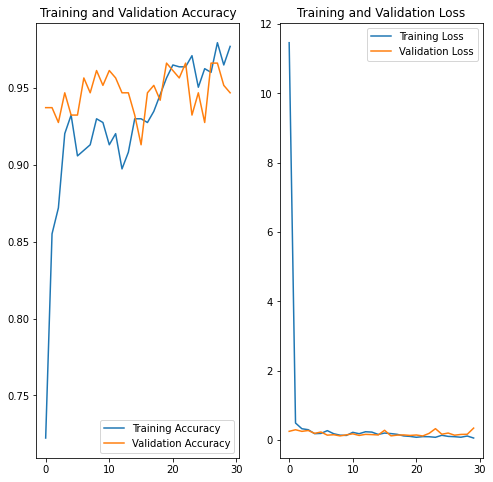

In [ ]:
#Plot the training progress

#Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

#Epochs
epochs_range = range(epoch_number)

#Plot - Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

#Plot - Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

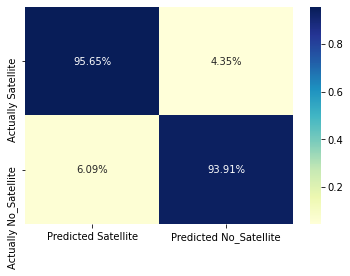

In [ ]:
#Pandas Flatten module
from pandas.core.common import flatten

#Extract labels and predictions for validation data of the model
y_pred_list = []
y_real_list = []
for images, labels in val_ds:
  #Prediction
  class_pr = (model.predict(images) > 0.5).astype("int32")
  y_pred_list.append(class_pr)
  #Label
  lab = list(np.ndarray.flatten(labels.numpy()))
  y_real_list.append(lab)
y_real = list(flatten(y_real_list))
y_pred = list(flatten(y_pred_list))

#Confusion matrix module
from sklearn.metrics import confusion_matrix
#Modules for displaying the matrix
import seaborn as sns
import pandas as pd

#Calculates the values of the matrix
confusion_matrix_scores = confusion_matrix(y_real, y_pred, labels=[1, 0], normalize = "true")

#Draw and show the matrix
df = pd.DataFrame(confusion_matrix_scores, 
                  columns = ["Predicted Satellite", "Predicted No_Satellite"],
                  index = ["Actually Satellite", "Actually No_Satellite"])
sns.heatmap(df, annot=True, fmt=".2%", cmap="YlGnBu")
plt.show()

In [ ]:
#Extract true/false positive/negative values
tp, fn, fp, tn = confusion_matrix_scores.ravel()

#Calculate precision and recall + F1 score
precision = tp / (tp + fp)
recall =  tp / (tp + fn)
F1 = 2 * precision * recall / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1:",F1)

Precision: 0.94017094017094
Recall: 0.9565217391304348
F1: 0.9482758620689654


## Prediction of unknown images

In [ ]:
#Load image
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/ESA/Data/satellite_det/raw_images2/no_satellite/jbyp02010_jbyp02srq.jpg", 
    target_size = (img_height, img_width))

#Process the image to an array and then to a batch
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) #Create a batch

#Calculate the (binary) prediction
class_pr = (model.predict(img_array) > 0.5).astype("int32") #For binary prediction
score_pr = model.predict(img_array)
if class_pr == 0:
  score_pr = 1 - score_pr

#Print the result
print("This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[int(class_pr)], 100 *float(score_pr)))

This image most likely belongs to no_satellite with a 100.00 percent confidence.


## Analysis with test dataset

In [ ]:
#Mount Google Drive with this Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir test_predictions
#Import of the relevant modules
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
import pandas as pd

#Make predictions on test dataset
model = tf.keras.models.load_model("/content/drive/MyDrive/ESA/Colab/Image_Classifier_V1.0")

#Compiling of the model, loss function is binary
model.compile(optimizer = 'adam', #Adam automatically uses the best learning rate
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# image folder
folder_path = "/content/drive/MyDrive/ESA/Data/satellite_det/test/"
# dimensions of images
img_width, img_height = 600, 600

predictions = []

pathout = "/content/test_predictions/"
for img in os.listdir(folder_path):
    img_p = os.path.join(folder_path, img)
    img_p = image.load_img(img_p, target_size=(img_width, img_height))
    img_p = image.img_to_array(img_p)
    img_p = np.expand_dims(img_p, axis=0)
    class_pr = (model.predict(img_p) > 0.5).astype("int32")
    ids = str(img).replace(".jpg","")
    fileout = str(img)
    img = mpimg.imread(folder_path+img)
    plt.imshow(img,cmap= "gray")
    pred = ""
    if class_pr == 0:
      pred = "no_satellite"
    else:
      pred = "satellite"
    predictions.append([ids,pred])
    plt.title("Prediction: " + pred)
    plt.axis('off')
    plt.savefig(pathout + fileout, bbox_inches = 'tight',dpi=150)
    plt.close()

mkdir: cannot create directory ‘test_predictions’: File exists
[['ie4i01010_ie4i01u5q', 'no_satellite'], ['ie4i01010_ie4i01ucq', 'no_satellite'], ['ie4i01010_ie4i01u8q', 'no_satellite'], ['ie4i01010_ie4i01ugq', 'satellite'], ['ie1p02010_ie1p02kbq', 'no_satellite'], ['ie1p02010_ie1p02kcq', 'no_satellite'], ['ie1p02010_ie1p02kdq', 'no_satellite'], ['ie1p02010_ie1p02kgq', 'no_satellite'], ['ie1p02010_ie1p02kfq', 'no_satellite'], ['ie1p02010_ie1p02kiq', 'no_satellite'], ['ie3w02040_ie3w02aoq', 'satellite'], ['ie3w02040_ie3w02awq', 'no_satellite'], ['ie3w02030_ie3w02ahq', 'satellite'], ['ie4i14010_ie4i14abq', 'no_satellite'], ['ie3w02030_ie3w02ajq', 'satellite'], ['ie4i14010_ie4i14apq', 'no_satellite'], ['ie4i14010_ie4i14znq', 'no_satellite'], ['ie4i14010_ie4i14zvq', 'no_satellite'], ['iduf51010_iduf51m8q', 'no_satellite'], ['iduf51010_iduf51mcq', 'no_satellite'], ['iduf51010_iduf51mdq', 'no_satellite'], ['iduf51010_iduf51mgq', 'satellite'], ['ie4l08040_ie4l08l6q', 'no_satellite'], ['ie4l08

In [ ]:
data = pd.DataFrame(predictions,columns=["id","prediction"])
data.to_csv(pathout+"predictions.csv")
data

,id,prediction
0,ie4i01010_ie4i01u5q,no_satellite
1,ie4i01010_ie4i01ucq,no_satellite
2,ie4i01010_ie4i01u8q,no_satellite
3,ie4i01010_ie4i01ugq,satellite
4,ie1p02010_ie1p02kbq,no_satellite
...,...,...
429,jdkq01020_jdkq01d9q,no_satellite
430,jdkq01020_jdkq01diq,no_satellite
431,jdkq01020_jdkq01dkq,no_satellite
432,jdkq01020_jdkq01dvq,satellite


In [ ]:
#Zip the data to download
!zip -r /content/test_predictions.zip /content/test_predictions

  adding: content/test_predictions/ (stored 0%)
  adding: content/test_predictions/idpw02030_idpw02maq.jpg (deflated 1%)
  adding: content/test_predictions/idwna2010_idwna2swq.jpg (deflated 1%)
  adding: content/test_predictions/jdm92o020_jdm92odjq.jpg (deflated 1%)
  adding: content/test_predictions/idnd02040_idnd02lpq.jpg (deflated 1%)
  adding: content/test_predictions/jdkq09010_jdkq09kxq.jpg (deflated 1%)
  adding: content/test_predictions/jdjw02020_jdjw02fbq.jpg (deflated 1%)
  adding: content/test_predictions/jdm91b020_jdm91bm7q.jpg (deflated 1%)
  adding: content/test_predictions/ie4i14010_ie4i14abq.jpg (deflated 1%)
  adding: content/test_predictions/jdkq09010_jdkq09kmq.jpg (deflated 1%)
  adding: content/test_predictions/ie2y02030_ie2y02xjq.jpg (deflated 1%)
  adding: content/test_predictions/idt801010_idt801k7q.jpg (deflated 1%)
  adding: content/test_predictions/ie4l08040_ie4l08l6q.jpg (deflated 1%)
  adding: content/test_predictions/jdkc04010_jdkc04uxq.jpg (deflated 1%)
  a